# Training Perceptron with Genetic Algorithm
# Introduction
The problem:
In this assignment, we’ll be using both a Genetic Algorithm and Perceptron to perform binary classification on a breast cancer dataset. We will do the classification by finding a hyperplane which separates the data points of the two different classes, and we will compare the results of these two approaches. 

We have provided code stubs in this notebook to get you started, and give hints about the structure of the code.

You need to compare the performance of 2 algorithms on the dataset:
- Genetic Algorithm with variations as described later
- Perceptron Algorithm which you will code

You will need to submit a report along with the finished Jupyter notebook in which you should report the performances in the form of tables as well as plots.

![picture](https://drive.google.com/uc?export=view&id=1wRUX0I803AvXbbkWiD1r4_MKuE3mBQdr)

## Approach:  
Let’s start with a few definitions.
- Individual (aka “chromosome”): a plane in space. It is specified by a weight vector and a bias.
- Population: a collection of possible planes (i.e., collection of individuals)
- Parents: two planes that are combined to create a new plane
- Mating pool: a collection of parents that are used to create our next population (thus creating the next generation of plane)
- Fitness: a function that tells us how good each plane is (in our case, how effectively the plane separates the dataset)
- Mutation: a way to introduce variation in our population by randomly modifying values of the plane's coefficients
- Elitism: a way to carry the best individuals into the next generation    
  
Our GA will proceed in the following steps:
- 1. Create the population
- 2. Rank the population according to fitness in decreasing order
- 3. Select the mating pool
- 4. Breed
- 5. Mutate to create the next generation
- 6. Repeat  
Now, let’s see this in action.

In [423]:
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt
import operator
import math
from sklearn.datasets import load_breast_cancer
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [424]:
maxweight = 100.0 # This constant will be used to generate random weights and biases for planes

Here we load the dataset. It is a `(N, dim)` matrix containing a set of points in 30-dimensional space

In [425]:
breast_cancer = sklearn.datasets.load_breast_cancer()

dataset = breast_cancer.data
print("Shape of our dataset: ", dataset.shape)
dim = dataset.shape[1] # Dimension of each sample in the dataset

targets = breast_cancer.target   # Our labels


Shape of our dataset:  (569, 30)


We separate the data into X_train, X_test, Y_train, and Y_test using `train_test_split`.

In [426]:
X_train, X_test, Y_train, Y_test = train_test_split(dataset, targets, test_size = 0.2, stratify = targets, shuffle=True)

## Create necessary classes and functions
We first create a Plane class that will allow us to create and handle our planes. Again, these are represented by the w vector, and the b value. Within the Plane class, there is a `predictset` method, which generates predictions based on this plane and a given set of points.

For each point, if $x_{1}w_{1} + x_{2}w_{2} +...x_{dim}w_{dim} + b = x\cdot w + b > 0 $, we predict the point to have a label of 1. Otherwise, we predict the point to have a label of 0.

We have two fitness method. One of them finds the number of points that are correctly classified with this `Plane`. The other one should take the inverse of the sum of the distance of the misclassified vectors. In both cases, a larger fitness score is better. 

The `accuracy` method will run predictions and then determine the accuracy of those predictions. 

**To-do** (1.1) (3 points)
1. Complete `fitness_numcorrect` method. (1 point)
2. Complete `perceptron_fitness` method. (1 point)
3. Complete `accuracy` method. (1 point)

In [485]:
class Plane:
    def __init__(self, w, b):
        """
        w : Weight vector of size (dim,)
        b : Bias (float)
        """
        self.w = w
        self.b = b
    
    def __repr__(self):
        return ' '.join([str(x) for x in np.append(self.w, self.b)])
        
    def predictset(self, points):
        """
        points: Matrix containing set of points of size (n, dim)
        This function returns predictions for multiple examples
        """
        return np.where((np.dot(points , self.w) + self.b) > 0,1,0)
    
    def fitness_numcorrect(self, data, targets):
        """
        data : n x dim matrix
        targets : n x 1 matrix of 0's and 1's representing the ground truth classification
        output: An integer value. 
        Our first fitness function is defined to be the number of correctly classified points in the training dataset. 
        """
        predictions = self.predictset(data)
        correct = 0
        for i in range(len(targets)):
            if predictions[i] == targets[i]:
                correct += 1
        return correct
        #YOUR CODE HERE

    def perceptron_fitness(self, data, targets):
        """
        This is the 2nd fitness function which you should implement from the Perceptron
        lecture slides.
        
        """
        distance = 0
        for i in range(len(targets)):
            distance += Y_train[i] * (self.b + np.dot(data[i], self.w))
        return (-1/distance)
        #YOUR CODE HERE

    def fitness(self, data, targets, fitness_type):
        """
        Wrapper function for fitness.
        fitness_type is a string specifying which fitness function to use.
        """
        if fitness_type == "numcorrect":
            return self.fitness_numcorrect(data, targets)
        elif fitness_type == "perceptron_fitness":
            return self.perceptron_fitness(data, targets)

        print("Invalid fitness type")

    def accuracy(self, data, targets):
        """
        data : n x dim matrix
        targets : n x 1 matrix of 0's and 1's representing the ground truth classification
        This function should return the accuracy of the plane on the dataset
        """
        return self.fitness_numcorrect(data, targets)/len(targets)
        #YOUR CODE HERE
      

## Create our initial population
Plane generator.  
We now can make our initial population (aka first generation). To do so, we need a way to create a function that produces random planes. To create an individual, we randomly select the weights of the plane equation. Even though we are starting out with a completely random initial population, there is still a chance for convergence. 

The first function here produces one random individual, and in the next function, we create the whole initial population by repeatedly calling randomPlane().

**To-do** (1.2) (4 points)
1. Complete `randomPlane` function. `np.random.rand()` might be useful here. (1 point) 

2. Complete `initialPopulation` function. (1 point)

In [428]:
def randomPlane():
    """
    Creates a random hyperplane. The components are uniformly selected at random
    from -maxweight to maxweight
    
    input: None
    output: Plane class object 
    """
    rand_weights = np.random.uniform(low = -maxweight, high = maxweight, size = dim)
    rand_bias = np.random.uniform(low = -maxweight, high = maxweight)
    plane = Plane(rand_weights, rand_bias)
    return plane
    #YOUR CODE HERE
def initialPopulation(popSize):
    """
    Create inital population of a given size.
    Returns a list of random planes
    """
    pop_list = []
    for i in range(popSize):
        pop = randomPlane()
        pop_list.append(pop)
    return pop_list
    #YOUR CODE HERE

Note: we only have to use these functions to create the initial population. Subsequent generations will be produced through breeding and mutation.

## Create the genetic algorithm - Rank by Fitness
Rank individuals  
Next, the evolutionary fun begins. To simulate our “survival of the fittest”, we can make use of Fitness to rank each individual in the population. Our output will be an ordered list with the plane IDs and each associated fitness score.

In [429]:
def rankPopulation(population, fitness_type="numcorrect"):
    """
    This function sorts the given population in decreasing order of the fitness score.
    Returns a list of ordered pairs of (index, fitness) where index is the index of the
    individual within the population
    """
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = population[i].fitness(X_train, Y_train,fitness_type)
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

## Select the mating pool
There are a few options for how to select the parents that will be used to create the next generation. The most common approaches are either fitness proportionate selection (aka “roulette wheel selection”) or tournament selection:
- Fitness proportionate selection: The fitness of each individual relative to the population is used to assign a probability of selection. Think of this as the fitness-weighted probability of being selected.
- Tournament selection: A set number of individuals are randomly selected from the population and the one with the highest fitness in the group is chosen as the first parent. This is repeated to chose the second parent.  

Another design feature to consider is the use of elitism. With elitism, the best performing individuals from the population will automatically carry over to the next generation, ensuring that the most successful individuals persist.  
For the purpose of clarity, we’ll create the mating pool in two steps. First, we’ll use the output from rankPopulation to determine which planes to select in our selection function. Then, we set up the roulette wheel by calculating a relative fitness weight for each individual. Next, we compare a randomly drawn number to these weights to select our mating pool. We’ll also want to hold on to our best planes, so we introduce elitism. Ultimately, the selection function returns a list of plane IDs, which we can use to create the mating pool in the matingPool function.

**Algorithm for weighted random number selection:** Say we have an array of weights $W$, $w_{i}$ is the weight that is proportional to the probability of selecting number $i$. First, we need to find the prefix sum $p$ of each number.($p_{k}$ = sum of all the weights from i= 0 to i= k) $$ p_{k} = \sum_{i=0}^{i=k} w_{i}$$
Next, we randomly select a value between 0 and the largest prefix sum (the prefix sum of the last individual, which is also the sum of all weights). To return the selected number, we find the smallest index that corresponds to the prefix sum greater than the randomly chosen value.

**To-do** (1.3)
1. Complete `selection` function. (4 points)


In [430]:
def selection(popRanked, eliteSize):
    """
    popRanked: output of rankpopulation()
    eliteSize: number of highest ranked individuals we will retain in the next generation.
    This function returns a list of indices of individuals selected to form the mating pool.
    """
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked[eliteSize:]), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = df.cum_sum/df.Fitness.sum()
    ### Retaining the best individual in the population.
    for i in range(eliteSize):
        selectionResults.append(popRanked[i][0])
    # weighted random selection
    for i in range(eliteSize, len(popRanked)):
        pick = random.random()
        for j in range(len(popRanked)-eliteSize):
            if pick <= df.iat[j,3]:
                selectionResults.append(int(df.iat[j,0]))
                break
    return selectionResults
    #YOUR CODE HERE

Now that we have the IDs of the planes that will make up our mating pool from the selection function, we can create the mating pool. We’re simply extracting the selected individuals from our population.

**To-do**(1.4)
1. Complete `matingPool` function. (1 point)

In [431]:
def matingPool(population, selectionResults):
    """
    Create the mating pool.
    Returns a list Planes that has been selected. 
    """
    pool_list = []
    for i in selectionResults:
        pool_list.append(population[i])
    return pool_list
    #YOUR CODE HERE

## Breed
With our mating pool created, we can create the next generation in a process called crossover (aka “breeding”). Each plane can be represented by a combined list, containing the w vector followed by the b constant. 

In crossover_ordered, we randomly select a subset of the first parent string and then fill the remainder of the plane with the genes from the second parent in the order in which they appear. See the image below for an example. 

There is a crossover wrapper function, which is what gets called later on. Inside of this function, based on the passed crossover type, we call the appopriate function to be used in the genetic algorithm.

In addition to ordered crossover, you need to implement two additional crossover functions which you must devise.

![picture](parent_child.png)

**To-do** (1.5) (7 points)
1. Complete `crossover_ordered` function. (3 points)
2. Complete `your_own_crossover` function. (2 points)
3. Complete `your_own_crossover2` function. (2 points)

Optional : Name your crossover functions

In [432]:
def crossover_ordered(plane1, plane2):
    """
    plane1, plane2 : type Plane
    Ordered crossover as described in the write-up
    return: a new plane that is a child of plane1 and plane2. 
    """
    plane1_arr = np.append(plane1.w, plane1.b)
    plane2_arr = np.append(plane2.w, plane2.b)
    subset_start, subset_end = random.sample(range(len(plane1_arr) + 1), 2)
    
    if subset_start > subset_end:#swap if start and end in wrong order
        subset_start, subset_end = subset_end, subset_start
    child_arr = plane2_arr
    
    for i in range(subset_start, subset_end):
        child_arr[i] = plane1_arr[i]
        
    child = Plane(child_arr[:-1], child_arr[-1])
    return child
    #YOUR CODE HERE

def your_own_crossover(plane1, plane2):
    #single point crossover
    plane1_arr = np.append(plane1.w, plane1.b)
    plane2_arr = np.append(plane2.w, plane2.b)
    
    point = random.randint(0, len(plane1_arr))
    child_arr = plane2_arr
    
    for i in range(point, len(plane1_arr)):
        child_arr[i] = plane1_arr[i]
        
    child = Plane(child_arr[:-1], child_arr[-1])
    return child
    #YOUR CODE HERE

def your_own_crossover2(plane1, plane2):
    #uniform crossover
    plane1_arr = np.append(plane1.w, plane1.b)
    plane2_arr = np.append(plane2.w, plane2.b)
    
    random_indices = random.sample(range(len(plane1_arr)), int(len(plane1_arr)/2))
    child_arr = plane2_arr
    for i in random_indices:
        child_arr[i] = plane1_arr[i]
        
    child = Plane(child_arr[:-1], child_arr[-1])
    return child  
    #YOUR CODE HERE
    
def crossover(plane1, plane2, crossover_type):
    """
    Wrapper function for crossover. Returns the child formed by crossing over 
    plane1 and plane2. 
    crossover_type is a string specifying which crossover function to use.
    """
    if crossover_type == "ordered":
        return crossover_ordered(plane1, plane2)
    # INSERT YOUR OWN CROSSOVER FUNCTION NAMES HERE
    elif crossover_type == "your_own_crossover":
        return your_own_crossover(plane1, plane2)
    elif crossover_type == "your_own_crossover2":
        return your_own_crossover2(plane1, plane2)
    print("Crossover type invalid")
    return None

Next, we’ll generalize this to create our offspring population. We will use elitism to retain the elites from the current population. Then, we use the crossover wrapper function to fill out the rest of the next generation. 

**To-do** (1.6) (3 points)
1. Complete `breedPopulation`.

In [433]:
def breedPopulation(matingpool, eliteSize, crossover_type):
    """
    matingpool: list of individuals selected to form the mating pool
    eliteSize: number of highest ranked individuals preserved in the next generation
    crossover_type: string specifying which crossover function to use
    This function returns the new population created by pairing individuals from the matingpool 
    and calling the crossover function to return a child for each pair. 
    In order to fill out the rest of the next generation,
    we need population_size - elite_size random pairs of Planes. 
    """
    pairs_needed = len(matingpool) - eliteSize
    children = []
    for i in range(eliteSize + 1):
        children.append(matingpool[i])
    
    for i in range(pairs_needed):
        plane1 = random.choice(matingpool)
        plane2 = random.choice(matingpool)
        children.append(crossover(plane1, plane2, crossover_type))
    
    return children
    # YOUR CODE HERE


## Mutate
Mutation serves an important function in GA, as it helps to avoid local convergence by introducing novel weights/bias that will allow us to explore other parts of the solution space. In this assignment, we shall assume that we mutate a certain fraction of the population, as specified in the variable `mutationRate`.

Note that there can be several possible ways to mutate an individual for this problem. You need to decide on your own how to mutate an individual. One hint could be - change one or some of the weights to a random value.

**To-do** (1.7) (3 points)
1. Implement`mutate` and `mutatePopulation` functions. To generate a random index, you can use `random.randint`.

In [434]:
def mutate(individual, mutationRate):
    """
    individual: type Plane
    This function should mutate a single individual and return the mutated individual.
    Hints given in paragraph above
    """
    mutated_indices_count = int(mutationRate * len(individual.w))
    mutated_indices = np.random.randint(0, len(individual.w) - 1, size = mutated_indices_count)
    mutated = individual
    mutated_arr = np.append(mutated.w, mutated.b)
    for i in mutated_indices:
        mutated_arr[i] = mutated_arr[i] * (1 + np.random.uniform(-mutationRate, mutationRate))
    mutated = Plane(mutated_arr[:-1], mutated_arr[-1])
    return mutated
    # YOUR CODE HERE

Next, we can extend the mutate function to run through the new population.  
Please create a function to run mutation over entire population and return the new population.

In [435]:
def mutatePopulation(population, mutationRate, eliteSize):
    """
    This function should use the above mutate function to mutate each member of the population. Simply iterate over the 
    population and mutate each individual (excluding the elites) using the mutationRate. 
    It should then return the mutated population. 
    """
    
    new_pop = []
    for i in range(eliteSize):
        new_pop.append(population[i])
    for i in range(eliteSize + 1, len(population)):
        new_pop.append(mutate(population[i], mutationRate))
    
    return new_pop
    # YOUR CODE HERE

## Repeat
We’re almost there. Let’s pull these pieces together to create a function that produces a new generation. First, we rank the planes in the current generation using `rankPopulation`. We then determine our potential parents by running the `selection` function, which allows us to create the mating pool using the `matingPool` function. Finally, we then create our new generation using the `breedPopulation` function (passing in crossover_type) and then applying mutation using the `mutatePopulation` function.

**To-do** (1.8) (3 points)
1. Implement`nextGeneration`. (3 points)


In [436]:
def nextGeneration(currentGen, eliteSize, mutationRate, crossover_type, fitness_type):
    """
    This function takes in the current generation, eliteSize and mutationRate and should return the next generation.
    The size of the next_generation has to equal to the size of currentGen. 
    """
    ranked_pop = rankPopulation(currentGen, fitness_type)
    selected = selection(ranked_pop, eliteSize)
    pool = matingPool(currentGen, selected)
    bred_pop = breedPopulation(pool, eliteSize, crossover_type)
    next_generation = mutatePopulation(bred_pop, mutationRate, eliteSize)
    
    return next_generation
    #YOUR CODE HERE

###### Final step: Evolution in motion
We finally have all the pieces in place to create our GA! All we need to do is create the initial population, and then we can loop through as many generations as we desire. 

Of course we want to see how much we’ve improved, so we capture the initial and final training/testing fitness and accuracy.

The progress of evolution is also worth checking. We should record the fitness of the best individual at every generation. 



The input parameters:
1. `popSize`: The population size at each generation. 
2. `eliteSize`: The size of the elite population. 
3. `mutationRate`: The probabilty of an individual gets mutated. 
4. `generations`: The maxmium number of generations to run for. 
5. `crossover_type`: A string which specifies which crossover function to use.
6. `fitness_type` : A string which specifies which fitness_type method to use.

The outputs:
1. `bestPlane`: The Plane with the highest fitness score(`bestRoute_list[-1]`). 
3. `fitness_record`: A list of the best fitness from each generation.(For the purpose of plotting.) `fitness_record[0]` is the best fitness score from the first generation. 



We recommand the following settings. Feel free to apply settings beyond the recommended values. It is possible to have a flat fitness curve. The initial population can contain Planes that have a relatively high fitness:

1. `popSize` : 15-50 
2. `eliteSize`: 0.1 * `popsize`
3. `mutationRate`: > 0.1
4. `generation`: > 1000 



Advice for debugging:

First, I recommand checking the size of your population in every generation. Your algorithm will not run correctly if the population size changes between generations. Second, plot the `fitness_record` and see if it is increasing monotonically, or the elite population has not been retained properly.



**To-do** (1.8) (7 points)
1. Implement`geneticAlgorithm`. (3 points)
2. Run the `geneticAlgorithm` (1 point)
3. Plot the fitness vs generation curve. (2 points) 
4. Print the initial and final training/testing fitness and accuracy.(1 point)

In [437]:
def geneticAlgorithm(popSize, eliteSize, mutationRate, generations, crossover_type, fitness_type):
    """
    This function should run the genetic algorithm for the specified number of generations
    by following the process outlined  in the "Approach" section given earlier in this notebook. 
    It should print the initial and final training and testing accuracy as well as 
    initial and final fitness.
    It should also generate plots showing the training as well as testing fitness
    with respect to generations.
    """
    #1. Create the population
    pop = initialPopulation(popSize)
    init_rank = rankPopulation(pop)
    fitness_record = [init_rank[0][1]]
    bestPlane = pop[init_rank[0][0]]
    bestPlane_record = init_rank[0][1]
    print('init_train_fit = ', bestPlane.fitness(X_train, Y_train, 'numcorrect'))
    print('init_train_acc = ', bestPlane.accuracy(X_train, Y_train))
    print('init_test_fit = ', bestPlane.fitness(X_test, Y_test, 'numcorrect'))
    print('init_test_acc = ', bestPlane.accuracy(X_test, Y_test))
    
    #2. Rank the population according to fitness in decreasing order
    #3. Select the mating pool
    #4. Breed
    #5. Mutate to create the next generation
    #6. Repeat
    for i in range(generations):
        pop = nextGeneration(pop, eliteSize, mutationRate, crossover_type, fitness_type)
        pop_rank = rankPopulation(pop)
        fitness_record.append(pop_rank[0][1])
        if pop_rank[0][1] > bestPlane_record:
            bestPlane = pop[pop_rank[0][0]]
            bestPlane_record = pop_rank[0][1]
    
    print('final_train_fit = ', bestPlane.fitness(X_train, Y_train, 'numcorrect'))
    print('final_train_acc = ', bestPlane.accuracy(X_train, Y_train))
    print('final_test_fit = ', bestPlane.fitness(X_test, Y_test, 'numcorrect'))
    print('final_test_acc = ', bestPlane.accuracy(X_test, Y_test))
    
    plt.plot(fitness_record)
    
    return bestPlane, fitness_record
    #YOUR CODE HERE


# Part 2: Perceptron with Gradient Descent

In this section we will code up the perceptron algorithm with gradient descent.

In the following cell, we create the main Perceptron class and its necessary functions. The psuedocode for perceptron `fit` method is below:
```
def fit

Input: X, Y, epochs, learning_rate

Output: None

for each epoch:
    for each xi and yi in X and Y:
        y_predicted = predict(x)
        if y_predicted = 1 and yi = 0:
            w <- w - learning_rate * xi
            b <- b - learning_rate
        if y_predicted = 0 and yi = 1:
            w <- w + learning_rate * xi
            b <- b + learning_rate            

```

**To-do** 2.1 (4 points)
1. Complete `model` method. (1 point) Hint: Same as how our GA individual predicts. 
2. Complete `fit` method. Feel free to change the number of epochs and learning rate from the default values.  (3 points)
3. Train the perceptron and print the training/test accuracy. 

In [439]:
class Perceptron:
    def __init__(self):
        self.w = 0
        self.b = 0

    def model(self, x):
        """
        This function returns the prediction for a single example x
        """
        return np.where((np.dot(x , self.w) + self.b) > 0,1,0)
        #Your code here

    def predict(self, X):
        """ 
        returns the predictions for multiple examples X
        Size of X: (n, dim)
        """
        Y = []
        for x in X:
            res = self.model(x)
            Y.append(res)
        return np.array(Y)

    def fit(self, X, Y, epochs = 100, learning_rate = 0.01):
        """
        This function should train the perceptron by running gradient descent 
        through the entire dataset. The 
        perceptron algorithm can be found in the lecture slides. Psuedocode has been provided above
        """
        self.w = np.zeros(X.shape[1])
        
        for i in range(epochs):
            y_predicted = self.predict(X)
            for j in range(Y_train.shape[0]): # repeat for each point in Y_train
                if y_predicted[j] == 1 and Y[j] == 0:
                    self.w = self.w - (learning_rate * X[j])
                    self.b = self.b - learning_rate
                if y_predicted[j] == 0 and Y[j] == 1:
                    self.w = self.w + (learning_rate * X[j])
                    self.b = self.b - learning_rate
                    
        #Your code here

In [484]:
perceptron = Perceptron()


#Your code here
epochs = 1000
learning_rate = .01

perceptron.fit(X_train,Y_train, epochs, learning_rate)
Y_pred_test = perceptron.predict(X_test)
Y_pred_train = perceptron.predict(X_train)
#Return the perceptron test accuracy. 
print("Perceptron training accuracy:", accuracy_score(Y_pred_train, Y_train))
print("Perceptron test accuracy:", accuracy_score(Y_pred_test, Y_test))

Perceptron training accuracy: 0.8989010989010989
Perceptron test accuracy: 0.8859649122807017


# Part 3: Report and Submission Guidelines (15 points)

The purpose of this assignment is to compare the performance of the Genetic Algorithm in varying conditions and Perceptron for this problem. 

You need to implement a total of **3** crossover functions and **2** fitness functions, as well as **1** mutation function. You can choose any mutation rate or even a different mutation strategy which gives you the best testing performance.

The best way to compare different algorithms is to run many iterations, and record the results. For this assignment, each time you call the `geneticAlgorithm` function, you use a certain crossover and fitness function. There are 3 crossover functions and 2 fitness function, which means there are 6 possible combinations. We want to compare the performance of these different combinations with each other as well as with Perceptron Gradient Descent.

For each combination (ie. crossover_ordered paired with fitness1, crossover_ordered paired with fitness2) you should run the `geneticAlgorithm` function 5 times at least. Then, take the average final **testing** accuracy for this specific combination, and report these in a table. Also add the average accuracy of Perceptron with gradient descent algorithm to this table.

The final report should contain an accuracy table, that has the average final testing accuracies for each combination of the genetic algorithm. Additionally, for each combination, please produce one plot (pick one of the 5 or more iterations) that plots fitness versus number of generations.

You need to write the following in your report:
- Accuracies table as specified above (5 points)
- Training and testing fitness plots with respect to generation (5 points)
- Description of your mutation function as well as crossover functions (5 points)



##### Append the report to the PDF copy of your notebook.

init_train_fit =  285
init_train_acc =  0.6263736263736264
init_test_fit =  72
init_test_acc =  0.631578947368421
final_train_fit =  370
final_train_acc =  0.8131868131868132
final_test_fit =  95
final_test_acc =  0.8333333333333334
init_train_fit =  285
init_train_acc =  0.6263736263736264
init_test_fit =  72
init_test_acc =  0.631578947368421
final_train_fit =  285
final_train_acc =  0.6263736263736264
final_test_fit =  72
final_test_acc =  0.631578947368421
init_train_fit =  285
init_train_acc =  0.6263736263736264
init_test_fit =  72
init_test_acc =  0.631578947368421
final_train_fit =  361
final_train_acc =  0.7934065934065934
final_test_fit =  85
final_test_acc =  0.7456140350877193
init_train_fit =  360
init_train_acc =  0.7912087912087912
init_test_fit =  91
init_test_acc =  0.7982456140350878
final_train_fit =  360
final_train_acc =  0.7912087912087912
final_test_fit =  91
final_test_acc =  0.7982456140350878
init_train_fit =  285
init_train_acc =  0.6263736263736264
init_test

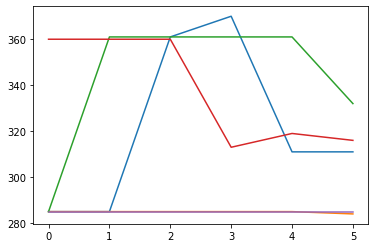

In [486]:
for i in range(5):
    geneticAlgorithm(15, 2, 0.2, 100, 'your_own_crossover2', "perceptron_fitness")